In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
import multiprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, export_text
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

random_state=100

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

En la ventana superior encontramos todas las librerias que vamos a necesitar para realizar el siguiente proyecto. En su mayoria son los basicos para tratar con dataframes, otros para poder plotearlos, tratamiento de fechas y analisis externo a su vez que la creacion de modelos y algoridmos.

Establecemos un random fijo, quitamos los warnings y nos quitamos el limite de dataframes para poder visualizar mejor los datos.


In [2]:
from pathlib import Path

data_path = Path('../data')

Para poder leer nuestros datos nos creamos un path que mas tarde ejecutaremos para poder nuestro csv de airbnb

In [3]:
data = pd.read_csv(data_path /'airbnb-listings-extract.csv', sep=';', encoding = "utf8", engine="python")
data.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,The loft is located on a gated property. Ther...,There is no public transportation from this lo...,The loft is entirely private to the guest as i...,My wife and I live on the property so we would...,The loft is entirely private but is adjacent t...,https://a0.muscache.com/im/pictures/c351a9b5-5...,https://a0.muscache.com/im/pictures/c351a9b5-5...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/c351a9b5-5...,58386783,https://www.airbnb.com/users/show/58386783,John,2016-02-11,My father was USAF so I was born at Offutt AFB...,I am a High Tech Professional with over 30 yea...,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/c5c78f08-f...,https://a0.muscache.com/im/pictures/c5c78f08-f...,NaN,1.0,1.0,"email,phone,reviews,kba","Canyon Edge Drive, Austin, TX 78733, United St...",NaN,78733,NaN,Austin,TX,78733,Austin,"Austin, TX",US,United States,30.337361,-97.863277,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Air con...",NaN,58.0,NaN,NaN,100.0,NaN,1,0,2,1125,today,NaN,10,34,64,281,2017-03-06,42,2016-03-13,2017-02-26,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,NaN,Ideal to discover the city either on foot or b...,Travellers will have access to the entire apar...,We will be more than happy to help you with an...,CHECK-IN Week Days: The check-in and key colle...,https://a0.muscache.com/im/pictures/3ce27aee-f...,https://a0.muscache.com/im/pictures/3ce27aee-f...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/3ce27aee-f...,102947901,https://www.airbnb.com/users/show/102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",Hola a todos! Soy Claudia Castillo y soy parte...,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/c071e13e-5...,https://a0.muscache.com/im/pictures/c071e13e-5...,NaN,162.0,162.0,"email,phone,reviews,work_email","Barcelona, Barcelona 08010, Spain",NaN,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08010,Barcelona,"Barcelona, Spain

In [4]:
data.shape

(14780, 89)

Nuestro dataframe se ha exportado bien, ya que consta de 89 variables y 14780 filas. De primeras en el .head() vemos que hay muchos datos que van a ser inservibles a la hora de realizar nuestro modelo, ya que no aportan ninguna informacion a nuestra variable objetivo "Price". Por ello el filtrado de datos lo vamos a dividir en dos partes. La primera parte sera donde filtraremos todas las variables categoricas, y la segunda parte filtrara las variables numericas. Esto lo hacemos ya que a la hora de filtrar las variables categoricas nos enfocaremos en hacer un primer analisis visual de nuestro csv, donde buscaremos que variables no aportan informacion al precio, y acto seguido haremos un analisis dentro de python, en el que basandonos en la uniquicidad que contenga cada variable, sabremos si puede aportar a nuestro modelo. 
Que haya muchos valores unicos categoricos en nuestro modelo, nos da mas complejidad y a su vez una menor calidad a nuestro modelo ya que las posibilidades son mas altas y hay menos casos. Esto no se aplica a los valores numericos.

In [5]:
cat_features = (data.dtypes[data.dtypes == 'object']
                .index.to_list())
num_features = (data.dtypes[data.dtypes != 'object']
                .index.to_list())

Los dividimos en dos listas, una para categoricas u objetos, y la otra para valores numericos

In [6]:
data[cat_features].columns

Index(['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Space',
       'Description', 'Experiences Offered', 'Neighborhood Overview', 'Notes',
       'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url',
       'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 'Host Name',
       'Host Since', 'Host Location', 'Host About', 'Host Response Time',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Verifications', 'Street', 'Neighbourhood',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City',
       'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
       'Country', 'Property Type', 'Room Type', 'Bed Type', 'Amenities',
       'Calendar Updated', 'Has Availability', 'Calendar last Scraped',
       'First Review', 'Last Review', 'License', 'Jurisdiction Names',
       'Cancellation Policy', 'Geolocation', 'Features'],
      dtype='object')

Haciendo un repaso a las variables, vemos que tenemos tres de tipo fechas, por lo que para poder tratar con ellas decidimos en convertirlas a valores numericos.

In [7]:
data[['First Review','Last Review']] = data[['First Review','Last Review']].apply(pd.to_datetime)
data['Days Between Firs and Last'] = (data['Last Review'] - data['First Review']).dt.days

In [8]:
dia_entrega = datetime.date(2022, 6, 14)
data['Host Since total days'] = dia_entrega
data[['Host Since','Host Since total days']] = data[['Host Since','Host Since total days']].apply(pd.to_datetime)
data['Host Since total days'] = (data['Host Since total days'] - data['Host Since']).dt.days

La conversion es muy simple. First review y last review indican en que fecha se publico la primera review y en que fecha se publico la ultima review de la casa. Para simplificar estos datos y a su vez poder interpretarlos, creamos una nueva variable, la cual contiene cuantos dias han pasado desde la primera review hasta la ultima. Una vez creada las dos variables que hemos utilizado no seran necesarias por ello se eliminaran mas adelante.
Y para la otra variable de fecha, nos indica la fecha en la que el Host empezo a ser Host en airbnb. Para poder cuantificarla establecemos una fecha referencia (en este caso el 14/06/2022 cuando se entrega el proyecto) y calculamos los dias que han pasado hasta esta fecha. Creamos una nueva variable con esta informacion y eliminaremos mas adelante la anterior.

In [9]:
data = data.drop(columns=['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', "Neighborhood Overview",
                          "Notes", "Transit", 'Access', "Interaction", "House Rules", 'Thumbnail Url', 'Medium Url', 
                          'Picture Url',  'XL Picture Url', "Host URL", "Host Name", 'Host Since', "Host Location",
                          "Host About", "Host Thumbnail Url", "Host Picture Url", "Host Neighbourhood", "Host Verifications",
                          "Street", "Neighbourhood", "Neighbourhood Cleansed", "Calendar Updated", "Calendar last Scraped",
                          'First Review', 'Last Review', "License","Jurisdiction Names", 'Geolocation', "Features" ])

Quitamos todas las variables categoricas que aparentemente no indican ningun tipo de caracteristica que pudiese influir al precio final de los apartamentos

In [10]:
data[num_features].columns

Index(['ID', 'Scrape ID', 'Host ID', 'Host Response Rate',
       'Host Listings Count', 'Host Total Listings Count', 'Latitude',
       'Longitude', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Square Feet', 'Price', 'Weekly Price', 'Monthly Price',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Calculated host listings count',
       'Reviews per Month'],
      dtype='object')

In [11]:
data[num_features].nunique()

ID                                14780
Scrape ID                            38
Host ID                            8935
Host Response Rate                   70
Host Listings Count                  56
Host Total Listings Count            56
Latitude                          14780
Longitude                         14780
Accommodates                         16
Bathrooms                            17
Bedrooms                             10
Beds                                 16
Square Feet                         103
Price                               370
Weekly Price                        388
Monthly Price                       586
Security Deposit                    124
Cleaning Fee                        111
Guests Included                      15
Extra People                         68
Minimum Nights                       43
Maximum Nights                      173
Availability 30                      31
Availability 60                      61
Availability 90                      91


Seguidamente revisamos nuestros datos numericos. A lo que podemos ver que muchas variables no nos sirve, unas porque son ID, numeros de identificacion, otras porque son coordenadas y por ultimo "Host Total Listings Count" que esta repetida. Tambien utilizaremos el ID general como nuestro index.

In [12]:
data = data.set_index(['ID'])

In [13]:
data = data.drop(columns=['Scrape ID',"Host ID", 'Latitude', 'Longitude', "Host Total Listings Count",])

In [14]:
cat_features = (data.dtypes[data.dtypes == 'object']
                .index.to_list())
num_features = (data.dtypes[data.dtypes != 'object']
                .index.to_list())

Volvemos a crear las listas con los datos restantes y seguimos con el proceso de filtrado

In [15]:
data[cat_features].columns

Index(['Experiences Offered', 'Host Response Time', 'Host Acceptance Rate',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Property Type',
       'Room Type', 'Bed Type', 'Amenities', 'Has Availability',
       'Cancellation Policy'],
      dtype='object')

In [16]:
data[cat_features].nunique()

Experiences Offered                 5
Host Response Time                  4
Host Acceptance Rate               12
Neighbourhood Group Cleansed       49
City                              246
State                             102
Zipcode                           619
Market                             43
Smart Location                    257
Country Code                       18
Country                            17
Property Type                      22
Room Type                           3
Bed Type                            5
Amenities                       12379
Has Availability                    1
Cancellation Policy                 8
dtype: int64

In [17]:
data = data.drop(columns=['Host Acceptance Rate',"Neighbourhood Group Cleansed", 'City', 'State', "Zipcode",'Smart Location','Market','Country Code','Country','Property Type','Amenities'])

Hacemos drop de las variables categoricas con mucha variedad de valores y volvemos a ajustar nuestras listas

In [18]:
cat_features = (data.dtypes[data.dtypes == 'object']
                .index.to_list())
num_features = (data.dtypes[data.dtypes != 'object']
                .index.to_list())

In [19]:
100*data[cat_features].isna().sum()/data[cat_features].shape[0]

Experiences Offered     0.000000
Host Response Time     12.848444
Room Type               0.000000
Bed Type                0.000000
Has Availability       99.918809
Cancellation Policy     0.000000
dtype: float64

In [20]:
data[cat_features] = data[cat_features].fillna('NO VALUE')

Y rellenamos los valores NA's con un valor categorico conjunto

In [21]:
100*data[num_features].isna().sum()/data[num_features].shape[0]

Host Response Rate                12.848444
Host Listings Count                0.020298
Accommodates                       0.000000
Bathrooms                          0.372124
Bedrooms                           0.169147
Beds                               0.331529
Square Feet                       95.953992
Price                              0.115020
Weekly Price                      75.710419
Monthly Price                     75.906631
Security Deposit                  57.672530
Cleaning Fee                      41.224628
Guests Included                    0.000000
Extra People                       0.000000
Minimum Nights                     0.000000
Maximum Nights                     0.000000
Availability 30                    0.000000
Availability 60                    0.000000
Availability 90                    0.000000
Availability 365                   0.000000
Number of Reviews                  0.000000
Review Scores Rating              22.354533
Review Scores Accuracy          

El proceso con los datos numericos es distinto. Establecemos una medida de corte donde las variables con un 25% de contenido mayor de NA's, estas seran sutituidas por un valor fijo, y si contienen un valor 25% menor de NA's, estos seran sustituidos por la media de su variables.

In [22]:
# x >= 25, fillna(-99)
# x <= 25 .mean()

data['Host Response Rate'] = data['Host Response Rate'].fillna(value = data['Host Response Rate'].mean())
data['Host Listings Count'] = data['Host Listings Count'].fillna(value = data['Host Listings Count'].mean())
data['Bathrooms'] = data['Bathrooms'].fillna(value = data['Bathrooms'].mean())
data['Bedrooms'] = data['Bedrooms'].fillna(value = data['Bedrooms'].mean())
data['Beds'] = data['Beds'].fillna(value = data['Beds'].mean())
data['Price'] = data['Price'].fillna(value = data['Price'].mean())
data['Review Scores Rating'] = data['Review Scores Rating'].fillna(value = data['Review Scores Rating'].mean())
data['Review Scores Accuracy'] = data['Review Scores Accuracy'].fillna(value = data['Review Scores Accuracy'].mean())
data['Review Scores Cleanliness'] = data['Review Scores Cleanliness'].fillna(value = data['Review Scores Cleanliness'].mean())
data['Review Scores Checkin'] = data['Review Scores Checkin'].fillna(value = data['Review Scores Checkin'].mean())
data['Review Scores Communication'] = data['Review Scores Communication'].fillna(value = data['Review Scores Communication'].mean())
data['Review Scores Location'] = data['Review Scores Location'].fillna(value = data['Review Scores Location'].mean())
data['Review Scores Value'] = data['Review Scores Value'].fillna(value = data['Review Scores Value'].mean())
data['Calculated host listings count'] = data['Calculated host listings count'].fillna(value = data['Calculated host listings count'].mean())
data['Reviews per Month'] = data['Reviews per Month'].fillna(value = data['Reviews per Month'].mean())
data['Days Between Firs and Last'] = data['Days Between Firs and Last'].fillna(value = data['Days Between Firs and Last'].mean())
data['Host Since total days'] = data['Host Since total days'].fillna(value = data['Host Since total days'].mean())

data['Square Feet'] = data['Square Feet'].fillna(-99)
data['Weekly Price'] = data['Weekly Price'].fillna(-99)
data['Monthly Price'] = data['Monthly Price'].fillna(-99)
data['Security Deposit'] = data['Security Deposit'].fillna(-99)
data['Cleaning Fee'] = data['Cleaning Fee'].fillna(-99)


In [23]:
100*data.isna().sum()/data.shape[0]

Experiences Offered               0.0
Host Response Time                0.0
Host Response Rate                0.0
Host Listings Count               0.0
Room Type                         0.0
Accommodates                      0.0
Bathrooms                         0.0
Bedrooms                          0.0
Beds                              0.0
Bed Type                          0.0
Square Feet                       0.0
Price                             0.0
Weekly Price                      0.0
Monthly Price                     0.0
Security Deposit                  0.0
Cleaning Fee                      0.0
Guests Included                   0.0
Extra People                      0.0
Minimum Nights                    0.0
Maximum Nights                    0.0
Has Availability                  0.0
Availability 30                   0.0
Availability 60                   0.0
Availability 90                   0.0
Availability 365                  0.0
Number of Reviews                 0.0
Review Score

Vemos que no quedan NA's en nuestras variables

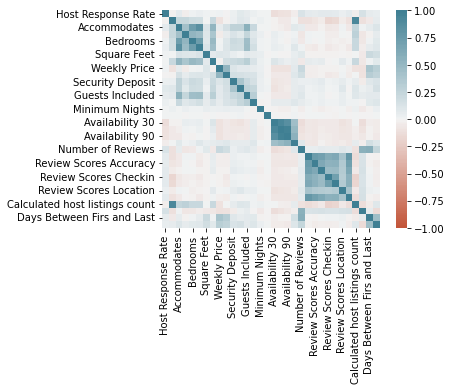

In [24]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [25]:
data[data.columns[0:]].corr()['Price'][:]

Host Response Rate                0.005620
Host Listings Count               0.226423
Accommodates                      0.520879
Bathrooms                         0.384002
Bedrooms                          0.495893
Beds                              0.440383
Square Feet                       0.074827
Price                             1.000000
Weekly Price                     -0.012068
Monthly Price                     0.178781
Security Deposit                  0.198906
Cleaning Fee                      0.231593
Guests Included                   0.300737
Extra People                      0.125151
Minimum Nights                    0.027424
Maximum Nights                    0.001530
Availability 30                   0.110145
Availability 60                   0.068133
Availability 90                   0.035944
Availability 365                  0.061207
Number of Reviews                -0.058535
Review Scores Rating              0.048830
Review Scores Accuracy            0.044411
Review Scor

Miramos las correlaciones de nuestros datos con nuestra variable objetivo "Price", y descartamos aquellas que no tengan correlacion positiva o negativa con la variable objetivo. Ya que estas no aportan a 'Price'

In [26]:
# x >= 10 u -10 <= x
data = data.drop(columns=['Host Response Rate','Square Feet','Weekly Price','Minimum Nights','Maximum Nights','Availability 60',
                          'Availability 90','Availability 365','Number of Reviews','Review Scores Rating','Review Scores Accuracy',
                          'Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location',
                          'Review Scores Value','Reviews per Month','Days Between Firs and Last','Host Since total days'])

data.shape

(14780, 19)

In [27]:
cat_features = (data.dtypes[data.dtypes == 'object']
                .index.to_list())
num_features = (data.dtypes[data.dtypes != 'object']
                .index.to_list())

In [28]:
data[num_features].shape

(14780, 13)

In [29]:
data[num_features].columns

Index(['Host Listings Count', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Availability 30',
       'Calculated host listings count'],
      dtype='object')

A la hora de crear nuestro modelo queremos quedarnos con las variables que puedan aportar informacion a nuestro modelo, por ello queremos qedarnos con aquellas que o bien esten positivamente relacionadas por encima de 0.1 o bien esten negativamente relacionadas por debajo de -0.1.
Tras realizar de nuevo el filtrado, nos quedamos solo con 30 varables.

Este sera nuestro dataframe que utilizaremos en su mayoria para crear nuestros modelos

In [30]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=100)

In [31]:
# mediante sklearn:


# Esta segunda es más recomendable debido a que :
# - Lo hacemos en dos pasos. Con el primer paso calculamos los parámetros mean and std que quedarán embbebidos en el objeto scaler:
scaler = StandardScaler()
train_scaler = scaler.fit(train_data[num_features])

# - después normalizamos el conjunto de datos que queramos con dichos parámetros. Es necesario crear un dataframe nuevo ya que estos métodos
# devuelven un array numpy
datos_scaled = pd.DataFrame(index=train_data[num_features].index, columns=train_data[num_features].columns, 
                            data=train_scaler.transform(train_data[num_features]))

datos_scaled.shape

(10346, 13)

Finalmente creamos nuestros train_data y nuestro test_data, con una proporcion de 0.3 a 0.7, del cual normalizaremos el train_data que sera el que utilicemos mas adelante.

#### Analisis Exploratorio

Para realizar un analisis exploratorio decidimos usar las herramientas de modelos no supervisados, esto es un tsne, un kernel, un pca y una inertia, para visualizar y determinar el posible numero de clusters de nuestro dataframe.

In [32]:
# T-sne

from sklearn.manifold import TSNE

tsne_1 = TSNE(n_components=2, perplexity= 1000)
tsne_2 = TSNE(n_components=2, perplexity= 100)
tsne_3 = TSNE(n_components=2, perplexity= 10)
tsne_4 = TSNE(n_components=2, perplexity= 1)

data_tsne_1 = tsne_1.fit_transform(datos_scaled)
data_tsne_2 = tsne_2.fit_transform(datos_scaled)
data_tsne_3 = tsne_3.fit_transform(datos_scaled)
data_tsne_4 = tsne_3.fit_transform(datos_scaled)

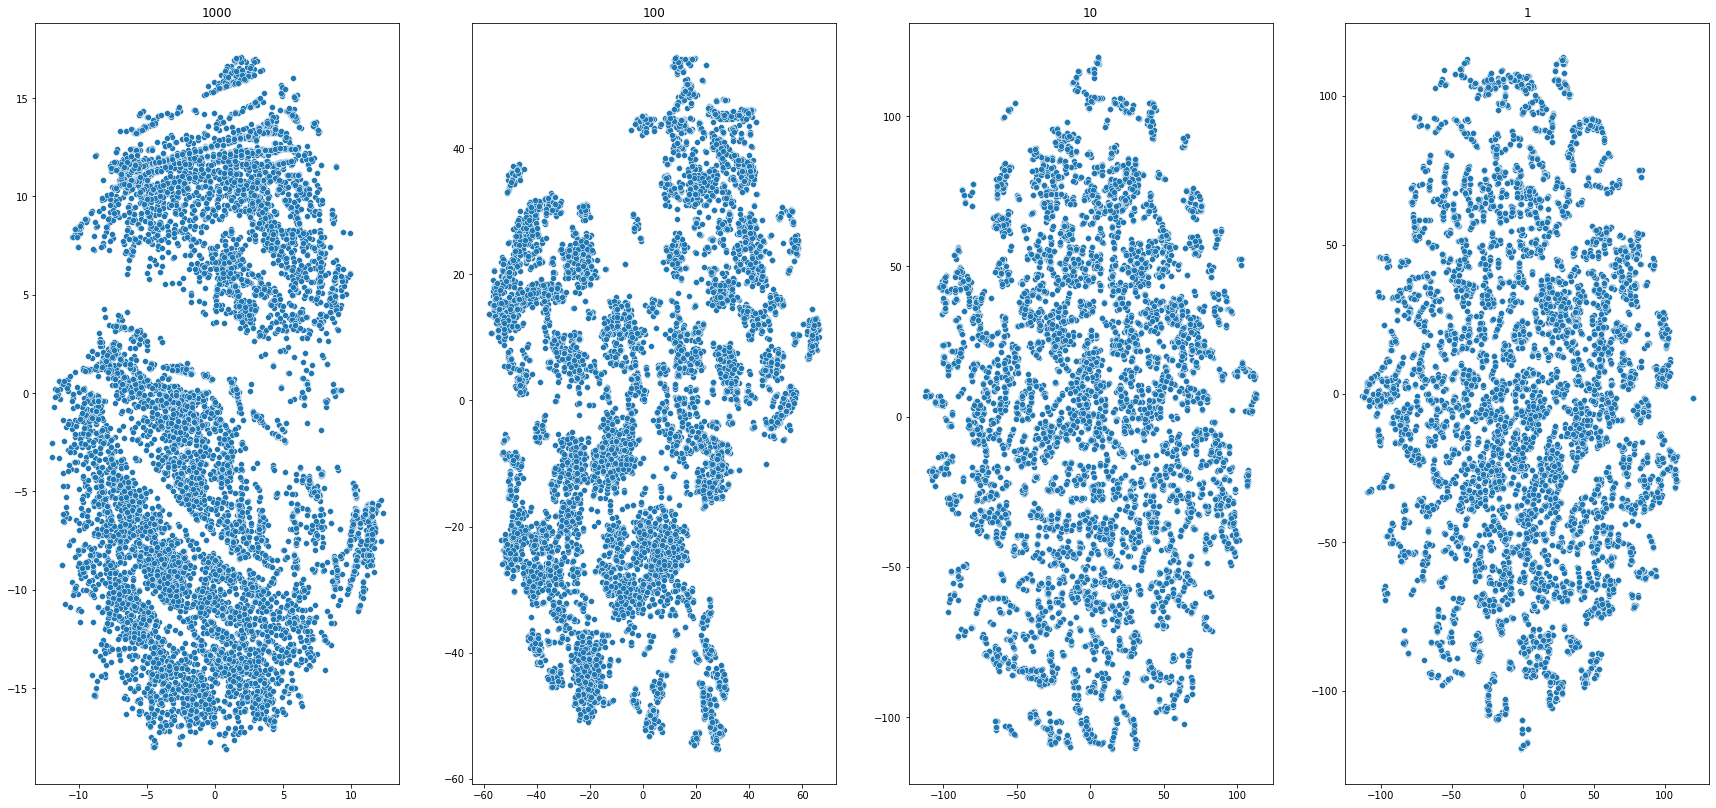

In [33]:
fig, ax = plt.subplots(1,4, figsize=(30,14))
sns.scatterplot(x=data_tsne_1[:,0],
                   y=data_tsne_1[:,1],
                   ax=ax[0])
sns.scatterplot(x=data_tsne_2[:,0],
                   y=data_tsne_2[:,1],
                   ax=ax[1])
sns.scatterplot(x=data_tsne_3[:,0],
                   y=data_tsne_3[:,1],
                   ax=ax[2])
sns.scatterplot(x=data_tsne_4[:,0],
                   y=data_tsne_4[:,1],
                   ax=ax[3])

ax[0].set_title('1000')
ax[1].set_title('100')
ax[2].set_title('10')
ax[3].set_title('1')
plt.show()

Realizamos un tsne como analisis exploratorio. Podemos apreciar que o bien hay dos clusters o bien a medida que la perplejidad baja, los clusters aumentan 

In [34]:
# Kernel

from sklearn.decomposition import KernelPCA

kpca = KernelPCA(14,kernel='rbf')

k_transformed = kpca.fit_transform(datos_scaled)

In [35]:
# PCA

from sklearn.decomposition import PCA

pca= PCA(13,random_state=random_state, whiten=False)

data_transformed=pca.fit_transform(datos_scaled)

Text(0.5, 1.0, 'PCA')

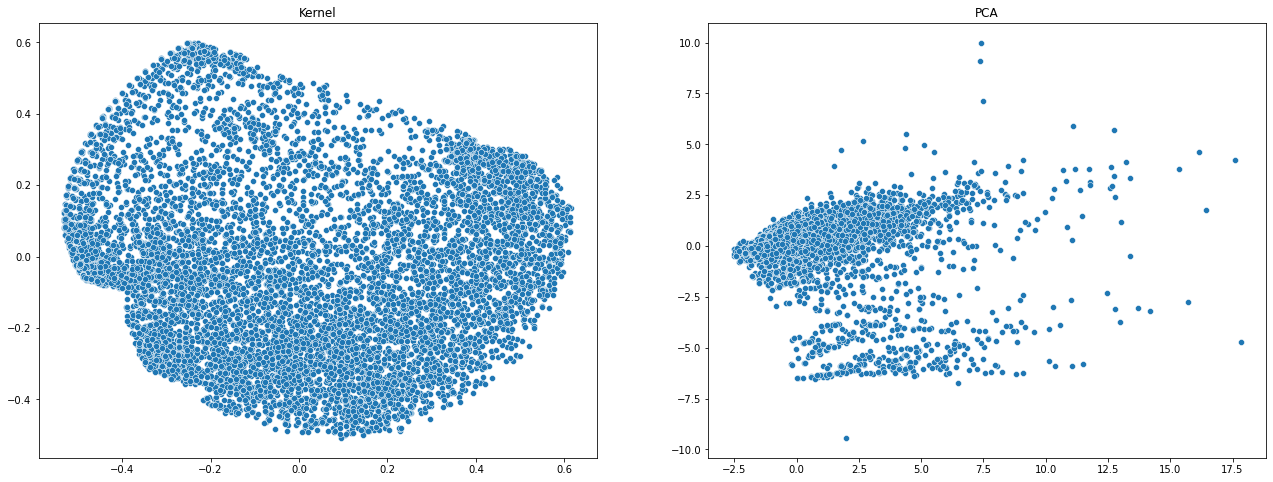

In [36]:
fig, ax = plt.subplots(1,2, figsize=(22,8))

sns.scatterplot(x=k_transformed[:,0],y=k_transformed[:,1], ax=ax[0])
sns.scatterplot(x=data_transformed[:,0],y=data_transformed[:,1], ax=ax[1])

ax[0].set_title('Kernel')
ax[1].set_title('PCA')

El Kernel apoya nuestra idea anterior de que hay un unico cluster, y el pca nos muestra un cluster bien marcado y puede que entre uno y dos mas,aunque litidamente marcados en la parte inferior derecha del grafico.

[0.31629168 0.45555068 0.56080246 0.64007525 0.71202585 0.77971602
 0.8309976  0.87942086 0.92072522 0.96028583 0.98281768 0.99379659
 1.        ]


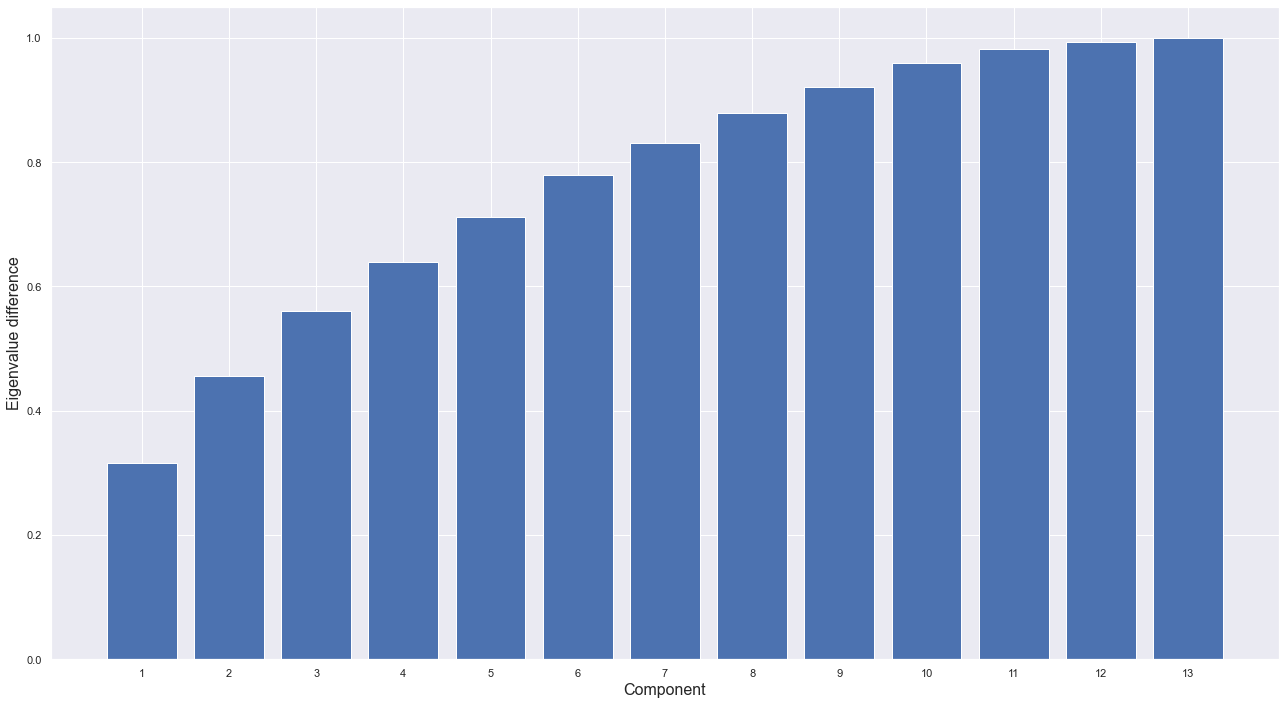

''

In [37]:
Xcov = np.cov(datos_scaled.T)
l, v = np.linalg.eig(Xcov)
l = np.sort(l)[::-1]
d = l[:l.shape[0] - 1] - l[1:]
cs=np.cumsum(l)/np.sum(l)
sns.set()
print(cs)

fig, ax = plt.subplots(figsize=(22, 12))

ax.bar(np.arange(1, len(cs) + 1, 1), cs)
ax.set_xticks(np.arange(1, len(cs) + 1, 1))
ax.set_xlabel('Component', fontsize=16)
ax.set_ylabel('Eigenvalue difference', fontsize=16)

plt.show()
;

In [38]:
# Compute the inertia

inertias = []

for i in range(2, 51):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=random_state)
    km.fit(datos_scaled)
    inertias.append(km.inertia_)

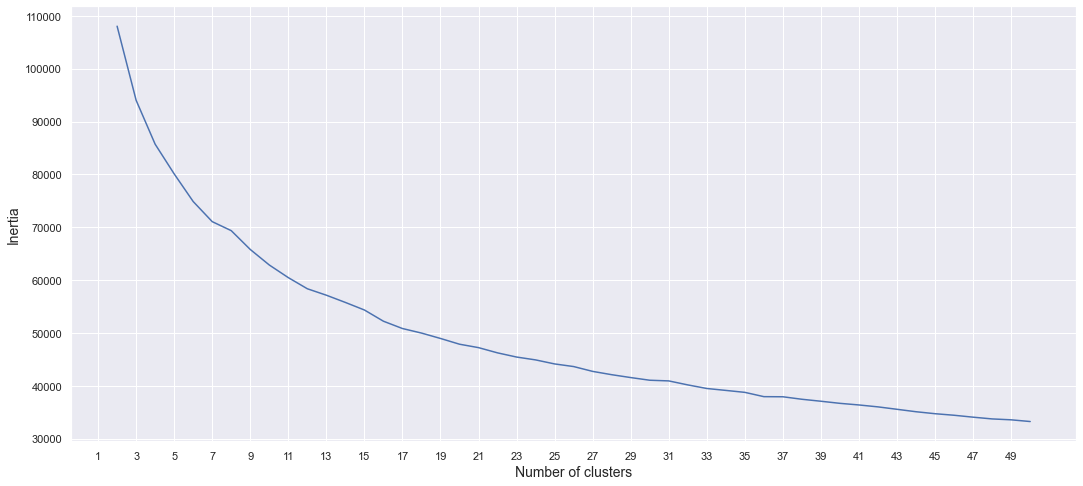

In [39]:
# Show the plot inertia vs. no. clusters

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(np.arange(2, 51, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(1, 51, 2))

plt.show()

Nuestro grafico de barras apoyaria la hipotesis de solo tener un unico cluster, mientras que nuestro grafico inertia apoyaria la idea de 8 clusters, segun la regla del codo

### Modelos

#### KNN

In [40]:
datos_modelos = datos_scaled
datos_modelos.shape

(10346, 13)

Seleccionamos la variable a predecir del resto y comprobamos que los tamaños de los dos resultantes sean compatibles.

In [41]:
x = datos_scaled['Price']

y = datos_scaled.drop(columns='Price')

print(x.shape,y.shape)

(10346,) (10346, 12)


In [42]:
train_x, test_x = train_test_split(x, test_size=0.3, random_state=100)
train_y, test_y = train_test_split(y, test_size=0.3, random_state=100)

Dividimos en train y test ambos datasets para poder realizar las predicciones sin caer en overfitting.

In [43]:
# División de los datos en train y test
x1_train, x1_test, y1_train, y1_test = train_test_split(
                                        datos_scaled.drop(columns = "Price"),
                                        datos_scaled['Price'],
                                        random_state = random_state
                                    )
# Creación del modelo
# ==============================================================================
modelo_KNN = KNeighborsRegressor(
            n_neighbors=5
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_KNN.fit(x1_train, y1_train)

KNeighborsRegressor()

In [44]:
 # Error de test del modelo inicial

predicciones_KNN = modelo_KNN.predict(x1_test)

rmse_KNN = mean_squared_error(
        y_true  = y1_test,
        y_pred  = predicciones_KNN,
        squared = False
       )
print(f"El error (rmse) de test para el modelo de KNN es: {rmse_KNN}")

El error (rmse) de test para el modelo de KNN es: 0.6660364462610326


Una vez conocemos nuestras predicciones computamos el MSE para poder compararar más adelante cual de todos los modelos que vamos a comparar es más adecuado para nuestras varibles.

#### GRADIENT BOOST

In [45]:
# División de los datos en train y test
x1_train, x1_test, y1_train, y1_test = train_test_split(
                                        datos_scaled.drop(columns = "Price"),
                                        datos_scaled['Price'],
                                        random_state = random_state
                                    )
# Creación del modelo

modelo = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = random_state
         )

# Entrenamiento del modelo

modelo.fit(x1_train, y1_train)

GradientBoostingRegressor(loss='ls', max_features='auto', n_estimators=10,
                          random_state=100)

El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, con forme se añaden árboles, se incrementa el riesgo de overfitting.

Valor óptimo de n_estimators: 476


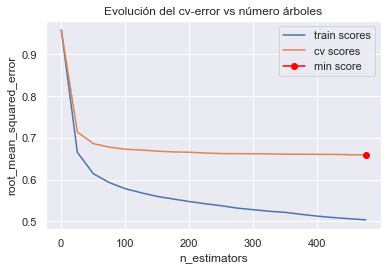

In [46]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error

train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.

for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'ls',
                max_features = 'auto',
                random_state = random_state
             )
    
    # Error de train
    modelo.fit(x1_train, y1_train)
    predicciones = modelo.predict(x1_train)
    rmse = mean_squared_error(
            y_true  = y1_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x1_train,
                y         = y1_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Los valores estimados por validación cruzada muestran que, a partir de los 25 árboles más o menos y el error del modelo se estabiliza, consiguiendo un mínimo con 151 árboles.

Por lo que volvemos a realizar el modelo con el número indicado de estimadores (101) y observamos el MSE resultante.

In [47]:
modelo = GradientBoostingRegressor(
            n_estimators = 101,
            loss         = 'ls',
            max_features = 'auto',
            random_state = random_state
         )

# Entrenamiento del modelo

modelo.fit(x1_train, y1_train)

GradientBoostingRegressor(loss='ls', max_features='auto', n_estimators=101,
                          random_state=100)

In [48]:
 # Error de test del modelo inicial

predicciones = modelo.predict(x1_test)

rmse_GB = mean_squared_error(
        y_true  = y1_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test para el modelo de GRADIENT BOOSTING es: {rmse_GB}")

El error (rmse) de test para el modelo de GRADIENT BOOSTING es: 0.6820217597464807


#### RANDOM FOREST 

In [49]:
#podemos usar los conjuntos x1 e y1 de train y test del modelo de Gradient Boosting anterior.

modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = random_state
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(x1_train, y1_train)

RandomForestRegressor(criterion='mse', n_estimators=10, n_jobs=-1,
                      random_state=100)

Al igual que lo ocurrido en el modelo Gradient Boosting, el modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Valor óptimo de n_estimators: 126


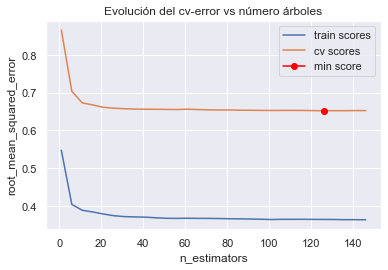

In [50]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error

train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(x1_train, y1_train)
    predicciones = modelo.predict(x1_train)
    rmse = mean_squared_error(
            y_true  = y1_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x1_train,
                y         = y1_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Ambas métricas indican que, a partir de 146 árboles, el error de validación del modelo se estabiliza.


El valor de máx_features es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí y en el modelo anterior se usa un valor aleatorio, así que siguiendo el mismo proceso encontraremos el número óptimo usando k-cross-validation y neg_root_mean_squared_error.

Valor óptimo de max_features: 4


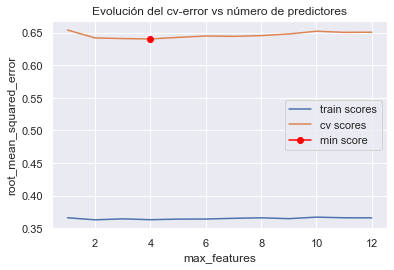

In [51]:
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, x1_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = random_state
             )
    
    # Error de train
    modelo.fit(x1_train, y1_train)
    predicciones = modelo.predict(x1_train)
    rmse = mean_squared_error(
            y_true  = y1_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x1_train,
                y         = y1_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

El valor óptimo de max_features está en 8.

In [52]:
#podemos usar los conjuntos x1 e y1 de train y test del modelo de Gradient Boosting anterior.

modelo = RandomForestRegressor(
            n_estimators = 146,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 8,
            oob_score    = False,
            n_jobs       = -1,
            random_state = random_state
         )

# Entrenamiento del modelo

modelo.fit(x1_train, y1_train)

RandomForestRegressor(criterion='mse', max_features=8, n_estimators=146,
                      n_jobs=-1, random_state=100)

In [53]:
# Error de test del modelo 

predicciones = modelo.predict(x1_test)

rmse_RF = mean_squared_error(
        y_true  = y1_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test de RANDOM FOREST es: {rmse_RF}")

El error (rmse) de test de RANDOM FOREST es: 0.6192449516983906


#### ÁRBOLES DE DECISIÓN

In [54]:
#podemos usar los conjuntos x1 e y1 de train y test del modelo de Gradient Boosting y Random Forest anteriores.

# Creación del modelo

modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = random_state
          )

# Entrenamiento del modelo

modelo.fit(x1_train, y1_train)

DecisionTreeRegressor(max_depth=3, random_state=100)

Profundidad del árbol: 3
Número de nodos terminales: 8


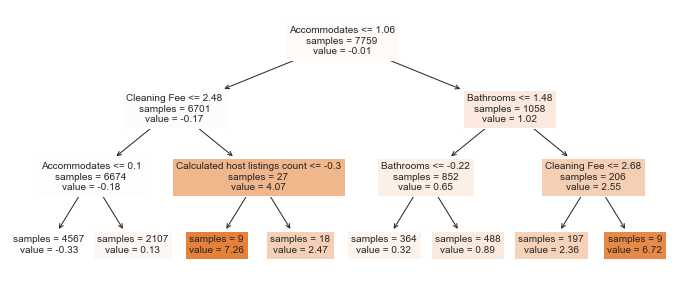

In [55]:
# Estructura del árbol creado

fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos_scaled.drop(columns = "Price").columns,
            class_names   = 'Price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

Basandonos en el arbol de decisión anterior podemos observar como en la rama central, el valor del Precio (normalizado) esperado para un Airbnb con unas Reviews per Month mayores de 0.4 (dato normalizado), Cleaning Fee mayor a 2.48 (normalizado), y con menos de 1.06 habitaciones (normalizado), el Precio (normalizado) esperado es de 9.09.

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el mse, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [56]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos_scaled.drop(columns = "Price").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo ÁRBOL DE DECISIÓN")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo ÁRBOL DE DECISIÓN


,predictor,importancia
1,Accommodates,0.522978
2,Bathrooms,0.218951
7,Cleaning Fee,0.212969
11,Calculated host listings count,0.045102
0,Host Listings Count,0.000000
3,Bedrooms,0.000000
4,Beds,0.000000
5,Monthly Price,0.000000
6,Security Deposit,0.000000
8,Guests Included,0.000000


Las Cleaning Fees junto con el número de estancias en la casa (Accommodates), han resultado ser las variables con mayor importancia.

Mientras que sorprende Square Feet, que a priori considerábamos que se podía tratar de una variable esencial, es en realidad la que menos aporta a este modelo.

Por último, se evalúa la capacidad predictiva del primer árbol y del árbol final empleando el conjunto de test.

In [57]:
predicciones = modelo.predict(x1_test)

rmse_AD = mean_squared_error(
        y_true  = y1_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test de ÁRBOLES DE DECISIÓN es: {rmse_AD}")

El error (rmse) de test de ÁRBOLES DE DECISIÓN es: 0.8315693488300522


#### REGRESIÓN LINEAL 

In [58]:
X = datos_scaled.drop(columns='Price')
y = datos_scaled['Price']

In [59]:
lr = LinearRegression(normalize=False)
lr.fit(X,y)

LinearRegression(normalize=False)

In [60]:
lr.score(X,y)

0.3622453631205256

In [61]:
test_data_norm = pd.DataFrame(index=test_data[num_features].index,  columns=test_data[num_features].columns, data=train_scaler.transform(test_data[num_features]))
Xtest = test_data_norm.drop(columns='Price')
ytest = test_data_norm['Price']
predictions = lr.predict(Xtest)
lr.score(Xtest,ytest)

0.37110805638129807

In [62]:
predicted_data_norm = test_data_norm.copy()
predicted_data_norm['Price'] = predictions
predicted_data_unorm = pd.DataFrame(index=predicted_data_norm.index, columns=predicted_data_norm.columns, 
                                    data=train_scaler.inverse_transform(predicted_data_norm))
predicted_data_unorm['predicted_sale'] = predicted_data_unorm['Price']
predicted_data_unorm['Price'] = test_data['Price']
predicted_data_unorm[['Price','predicted_sale']].head(14)

,Price,predicted_sale
ID,,
17886112,120.0,78.805837
13106588,15.0,18.145124
8493437,25.0,81.175463
18073681,56.0,67.069961
7097089,110.0,126.678885
15609946,65.0,55.461968
15200971,11.0,112.816721
3810142,25.0,82.248643
12661597,57.0,91.821075


In [63]:
rmse = np.sqrt(((predicted_data_unorm['Price'] - predicted_data_unorm['predicted_sale'])**2).mean())
rmse

53.74912475994109

In [64]:
rmse_RLin = mean_squared_error(predicted_data_unorm['Price'], predicted_data_unorm['predicted_sale'], squared=False)/100
rmse_RLin

0.5374912475994101

In [65]:
n = test_data[num_features].shape[0]
parameters = test_data[num_features].shape[1]
rse =  np.sqrt(((predicted_data_unorm['Price'] - predicted_data_unorm['predicted_sale'])**2).sum()/(n-parameters))
print(rse)
100*rse/test_data[num_features]['Price'].mean()

53.82809170333884


74.55610716692726

#### REGRESIÓN LOGÍSTICA 

Lo primero que debemos tener para poder realizar una regresión logística es una variable binaria, que hemos llamado CATEGORY, que variará entre 0 y 1 según la variable PRICE de cada Airbnb sea mayor o menos que la mediana.

In [66]:
datos_scaled["Category"] = (datos_scaled["Price"] >= datos_scaled["Price"].median()).astype(int)
datos_scaled.head()

,Host Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Availability 30,Calculated host listings count,Category
ID,,,,,,,,,,,,,,
14269186,-0.338258,0.820647,2.633062,0.731355,-0.024891,2.384354,-0.395506,-0.758010,-1.115414,-0.496761,-0.587065,-0.955438,-0.361559,1
9851358,-0.338258,-0.135265,-0.433023,-0.383599,-0.024891,-0.056211,-0.395506,1.099072,0.473736,-0.496761,-0.587065,0.535362,-0.361559,1
13899378,-0.338258,-0.613222,-0.433023,-0.383599,-0.651895,-0.666353,-0.395506,0.415865,-1.115414,-0.496761,0.556815,0.641848,-0.361559,0
15122527,0.248313,0.342691,-0.433023,-0.383599,0.602112,1.164071,-0.395506,-0.758010,-1.115414,-0.496761,-0.587065,0.109419,0.151594,1
6637689,-0.074301,-0.613222,-0.433023,-0.383599,-0.651895,-0.666353,-0.395506,-0.758010,0.429998,0.353725,0.556815,-0.529495,0.023306,0


In [67]:
print("Número de Airbnbs por categoría")
print(datos_scaled['Category'].value_counts())
print("")

print("Porcentaje de Airbnbs por categoría")
print(100 * datos_scaled['Category'].value_counts(normalize=True))

Número de Airbnbs por categoría
1    5180
0    5166
Name: Category, dtype: int64

Porcentaje de Airbnbs por categoría
1    50.067659
0    49.932341
Name: Category, dtype: float64


Podemos ver como ambos grupos son bastante parecidos con una mínima diferencia de valores entre ellos.

Un modelo de clasificación que sea útil debe de ser capaz de predecir correctamente un porcentaje de observaciones por encima del porcentaje de la clase mayoritaria. En este caso, el umbral de referencia que se tiene que superar es del 50.068%.

In [68]:
# División de los datos en train y test

x_3 = datos_scaled.drop(columns = 'Category')
y_3 = datos_scaled['Category']

x3_train, x3_test, y3_train, y3_test = train_test_split(
                                        x_3,
                                        y_3.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = random_state,
                                        shuffle      = True
                                    )

In [69]:
# Creación del modelo utilizando matrices como en scikitlearn

# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo

modelo = sm.Logit(endog=y3_train, exog=x3_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.224034
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8276
Model:                          Logit   Df Residuals:                     8263
Method:                           MLE   Df Model:                           12
Date:                Tue, 14 Jun 2022   Pseudo R-squ.:                  0.6768
Time:                        17:27:46   Log-Likelihood:                -1854.1
converged:                       True   LL-Null:                       -5736.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Host Listings Count                0.1252      0.117      1.069     

In [70]:
# Predicciones con intervalo de confianza 
# ==============================================================================
predicciones = modelo.predict(exog = x3_train)

# Clasificación predicha
# ==============================================================================
clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

array([0, 0, 0, ..., 1, 0, 1])

In [71]:
# Accuracy de test del modelo 
# ==============================================================================
predicciones = modelo.predict(exog = x3_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y3_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"La precisión del test es: {100*accuracy}%")


La precisión del test es: 89.7584541062802%


Con el valor de precisión en un 89,95%, podemos decir que supera claramente el umbral explicado anteriormente de 50%.

In [72]:
rmse_RLog = mean_squared_error(
        y_true  = y3_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test de la REGRESIÓN LOGÍSTICA es: {rmse_RLog}")

El error (rmse) de test de la REGRESIÓN LOGÍSTICA es: 0.26477752833142126


#### RESULTADO: MODELO ÓPTIMO  

In [73]:
print(f"El error (rmse) de test para el modelo de KNN es: {rmse_KNN}")
print(f"El error (rmse) de test para el modelo de GRADIENT BOOSTING es: {rmse_GB}")
print(f"El error (rmse) de test de RANDOM FOREST es: {rmse_RF}")
print(f"El error (rmse) de test de ÁRBOLES DE DECISIÓN es: {rmse_AD}")
print(f"El error (rmse) de test de REGRESIÓN LINEAL es: {rmse_RLin}")
print(f"El error (rmse) de test de la REGRESIÓN LOGÍSTICA es: {rmse_RLog}")

El error (rmse) de test para el modelo de KNN es: 0.6660364462610326
El error (rmse) de test para el modelo de GRADIENT BOOSTING es: 0.6820217597464807
El error (rmse) de test de RANDOM FOREST es: 0.6192449516983906
El error (rmse) de test de ÁRBOLES DE DECISIÓN es: 0.8315693488300522
El error (rmse) de test de REGRESIÓN LINEAL es: 0.5374912475994101
El error (rmse) de test de la REGRESIÓN LOGÍSTICA es: 0.26477752833142126


Con la comparativa de los Mean Squared Errors de todos los modelos utilizados, podemos observar claramente como el menor es el del modelo de REGRESIÓN LOGÍSTICA  con un valor de 0.26, y por lo tanto decidimos que se trata del modelo óptimo para predecir la variable de Price de los diferentes Airbnbs